In [1]:
import tensorflow as tf
import cv2
import numpy as np
from tensorflow import keras
from pathlib import Path
from natsort import natsorted

In [2]:
batch_size=10
patch_size=16
img_size=128
num_patches=(img_size//patch_size)**2
p_dim=256
num_encoder=6
heads_att=6
mlp_head=1024

In [3]:
target_class={0:"Normal",1:"Tuberculosis"}

In [4]:
Normal_dir=Path("TB_Chest_Radiography_Database/Normal/")
TB_dir=Path("TB_Chest_Radiography_Database/Tuberculosis/")

In [5]:
Normal_images:list=natsorted(list(map(str, list(Normal_dir.glob("*.png")))))
TB_images:list=natsorted(list(map(str, list(TB_dir.glob("*.png")))))

In [6]:
Normal_labels:list=[0]*len(Normal_images)
TB_labels:list=[1]*len(TB_images)

In [7]:
images=np.array(Normal_images+TB_images)
labels=np.array(Normal_labels+TB_labels)
images.shape, labels.shape

((4200,), (4200,))

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(images,labels,test_size=0.2,random_state=42)

In [10]:
import matplotlib.pyplot as plt

(-0.5, 511.5, 511.5, -0.5)

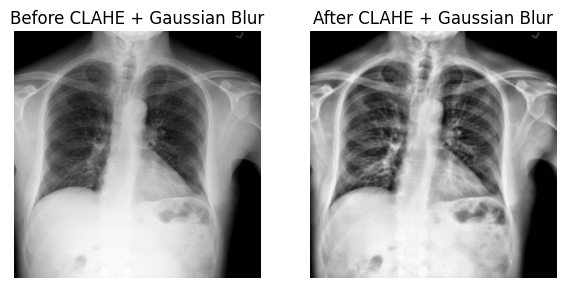

In [11]:
image_1=x_train[0]
image_1=cv2.imread(image_1)
image_1=cv2.cvtColor(image_1,cv2.COLOR_BGR2GRAY)
clahe=cv2.createCLAHE(2,(16,16))
image_1_equalized=clahe.apply(image_1)
image_1_equalized_blurred=cv2.GaussianBlur(image_1_equalized,(5,5),0)
_, ax = plt.subplots(1, 2, figsize=(7, 7))
ax[0].imshow(image_1,cmap='gray')
ax[0].set_title("Before CLAHE + Gaussian Blur")
ax[0].axis("off")
ax[1].imshow(image_1_equalized_blurred,cmap='gray')
ax[1].set_title("After CLAHE + Gaussian Blur")
ax[1].axis("off")

In [ ]:
def image_preprocessing(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    clahe=cv2.createCLAHE(3,(16,16))
    img=clahe.apply(img)
    img=cv2.GaussianBlur(img,(5,5),0)
    img=cv2.resize(img,(img_size,img_size))
    img=img.reshape(img_size,img_size,1)
    img=img/255.0
    return img

In [ ]:
x_train=np.array(list(map(image_preprocessing,x_train)))
x_train.shape

In [ ]:
x_valid=np.array(list(map(image_preprocessing,x_valid)))
x_valid.shape

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset=tf.data.Dataset.from_tensor_slices((x_valid,y_valid)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
_, ax = plt.subplots(1, 10, figsize=(14, 4))
for batch in train_dataset.take(1):
    images = batch[0]
    labels = batch[1]
    for i in range(batch_size):
        img = (images[i]*255).numpy().astype("uint8")
        label=labels[i].numpy()
        ax[i].imshow(img,cmap='gray')
        ax[i].set_title(target_class[label])
        ax[i].axis("off")

In [ ]:
_, ax = plt.subplots(1, 10, figsize=(14, 4))
for batch in validation_dataset.take(1):
    images = batch[0]
    labels = batch[1]
    for i in range(batch_size):
        img = (images[i]*255).numpy().astype("uint8")
        label=labels[i].numpy()
        ax[i].imshow(img,cmap='gray')
        ax[i].set_title(target_class[label])
        ax[i].axis("off")

In [ ]:
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_valid[np.random.choice(range(x_valid.shape[0]))]
plt.imshow((image*255).astype("uint8"),cmap='gray')
plt.axis("off")

image=tf.convert_to_tensor([image])

patches = Patches(patch_size)(image)
print(f"Image size: {img_size} X {img_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (16, 16, 1))
    plt.imshow((patch_img*255).numpy().astype("uint8"),cmap='gray')
    plt.axis("off")

In [ ]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def mlp(x, hidden_units):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
    return x

In [ ]:
def build_model():
    inputs=keras.layers.Input(shape=(img_size,img_size,1))
    patches=Patches(patch_size)(inputs)
    encoded=PatchEncoder(num_patches,p_dim)(patches)
    for _ in range(num_encoder):
        x1=keras.layers.LayerNormalization()(encoded)
        attention=keras.layers.MultiHeadAttention(num_heads=heads_att,key_dim=p_dim)(x1,x1)
        x2=keras.layers.Add()([attention,encoded])
        x3=keras.layers.LayerNormalization()(x2)
        x3=mlp(x3,[2*p_dim,p_dim])
        encoded=keras.layers.Add()([x3,x2])
    rep=keras.layers.GlobalAveragePooling1D()(encoded)
    rep=mlp(rep,hidden_units=[mlp_head,mlp_head//2])
    output=keras.layers.Dense(1,activation='sigmoid')(rep)

    model=keras.Model(inputs=inputs,outputs=output)
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt,
                  loss=keras.losses.BinaryFocalCrossentropy(),
                  metrics=[keras.metrics.Recall(),
                           keras.metrics.BinaryAccuracy()])
    return model

In [ ]:
model=build_model()
model.summary()

In [ ]:
keras.utils.plot_model(model,show_layer_activations=True,show_shapes=True)

In [ ]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,patience=10)
lr_scheduler=keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.05,patience=3,verbose=1,min_lr=1e-5)

In [ ]:
model.fit(train_dataset,validation_data=validation_dataset,epochs=100,callbacks=[early_stop,lr_scheduler])